In [1]:
import cv2
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
#import necessary libraries
import pandas as pd
import napari
import numpy as np
import skimage as sk
from scipy.interpolate import RectBivariateSpline

In [2]:
def apply_rescale_intensity(image, out_min=0.0, out_max=1.0):
    out_range = (out_min, out_max)
    rescaled_image = sk.exposure.rescale_intensity(image, out_range=out_range).astype(np.float32)
    return rescaled_image

In [3]:
from skimage.util import img_as_ubyte, img_as_uint, img_as_float32, img_as_float64

def dtype_conversion_func(img, output_bit_depth='16-bit'):
    """
    Convert the data type of an image to the desired bit depth using skimage functions.

    Parameters
    ----------
    img : array-like
        Input image.
    output_bit_depth : str, optional
        Desired output bit depth. Options: '8-bit', '16-bit', '32-bit', '64-bit'. Default is '16-bit'.

    Returns
    -------
    ndarray
        Image converted to the desired bit depth.
    """

    # Mapping bit depths to skimage functions
    bit_depth_func_map = {
        '8-bit': img_as_ubyte,
        '16-bit': img_as_uint,
        '32-bit': img_as_float32,
        '64-bit': img_as_float64
    }

    # Fetch the appropriate function for the desired output
    conversion_func = bit_depth_func_map.get(output_bit_depth)

    if conversion_func is None:
        raise ValueError(f"Unsupported output_bit_depth '{output_bit_depth}'.")

    # Apply the conversion function
    converted_image = conversion_func(img)

    return converted_image


In [4]:
def upscale_image_interp(image, num_row_initial, num_col_initial, upscale_factor=2):
    """
    Upscales an image using bicubic interpolation.
    """

    # Set parameters for image upscaling
    x0 = np.linspace(-0.5, 0.5, num_col_initial)
    y0 = np.linspace(-0.5, 0.5, num_row_initial)
    X0, Y0 = np.meshgrid(x0, y0)

    # Create a grid for the upscaled image
    #upscale_factor = 2 #5 / PSF # Upscaled image has 5 pixels per PSF (1/e radius) 
    #print("Upscale factor", upscale_factor)
    x = np.linspace(-0.5, 0.5, int(np.round(upscale_factor * num_col_initial)))
    y = np.linspace(-0.5, 0.5, int(np.round(upscale_factor * num_row_initial)))
    X, Y = np.meshgrid(x, y)

    # Interpolation
    interp_func = RectBivariateSpline(y0, x0, image)
    magnified_image = interp_func(y, x)
    magnified_image[magnified_image < 0] = 0
    magnified_image = np.pad(magnified_image, 10, mode='constant')

    return magnified_image

In [5]:
from perlin_noise import PerlinNoise

def generate_perlin_noise_image(octave_scalar1, octave_scalar2, octave_scalar3, octave_scalar4):

    noise1 = PerlinNoise(octaves=3)
    noise2 = PerlinNoise(octaves=9)
    noise3 = PerlinNoise(octaves=15)
    noise4 = PerlinNoise(octaves=24)

    xpix, ypix = 512, 512
    perlin_bg_img = []
    for i in range(xpix):
        row = []
        for j in range(ypix):
            noise_val = octave_scalar1 * noise1([i/xpix, j/ypix])
            noise_val += octave_scalar2 * noise2([i/xpix, j/ypix])
            noise_val += octave_scalar3 * noise3([i/xpix, j/ypix])
            noise_val += octave_scalar4 * noise4([i/xpix, j/ypix])

            row.append(noise_val)
        perlin_bg_img.append(row)
    
    perlin_bg_img = np.asarray(perlin_bg_img)

    return perlin_bg_img

In [6]:
# Create the viewer
viewer = napari.Viewer()

# Run the Napari event loop
napari.run()

In [195]:
# Load and process cell mask
mask = viewer.layers['Mask Layer'].data
mask = mask > 0  # Binarize the mask
labeled_cell_mask = sk.measure.label(mask)

In [196]:
from perlin_noise import PerlinNoise

def generate_perlin_noise_image(xpix, ypix, octave_scalar1, octave_scalar2, octave_scalar3, octave_scalar4):
    noise1 = PerlinNoise(octaves=2)
    noise2 = PerlinNoise(octaves=4)
    noise3 = PerlinNoise(octaves=6)
    noise4 = PerlinNoise(octaves=10)

    perlin_bg_img = []
    for i in range(xpix):
        row = []
        for j in range(ypix):
            noise_val = octave_scalar1 * noise1([i/xpix, j/ypix])
            noise_val += octave_scalar2 * noise2([i/xpix, j/ypix])
            noise_val += octave_scalar3 * noise3([i/xpix, j/ypix])
            noise_val += octave_scalar4 * noise4([i/xpix, j/ypix])
            row.append(noise_val)
        perlin_bg_img.append(row)
    
    perlin_bg_img = np.asarray(perlin_bg_img)
    return perlin_bg_img



def crop_bounding_box(roi_mask):
    rows, cols = np.where(roi_mask)
    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()
    cropped_mask = roi_mask[min_row:max_row+1, min_col:max_col+1]
    return cropped_mask, min_row, max_row, min_col, max_col



# Initialize output arrays
perlin_bg_img = np.zeros_like(mask, dtype=np.float64)
perlin_bg_dapi = np.zeros_like(mask, dtype=np.float64)

# Generate Perlin noise for each cell
for label in np.unique(labeled_cell_mask)[1:]:  # Skip background (0)
    cell_mask = labeled_cell_mask == label
    cropped_mask, min_row, max_row, min_col, max_col = crop_bounding_box(cell_mask)
    
    # Determine the size of the cropped area
    bbox_x_size = max_row - min_row + 1
    bbox_y_size = max_col - min_col + 1
    
    # Generate Perlin noise image sized to the bounding box
    noise = generate_perlin_noise_image(bbox_x_size, bbox_y_size, 0.65, 0.20, 0.10, 0.05)
    
    # Apply mask and assign to output
    masked_noise = noise * cropped_mask

    # Generate a random intensity between 0 and 1, ensure that the minimum is less than the maximum, and that they are at least 0.1 apart
    random_min_intensity = np.random.uniform(0.0, 1.0)
    random_max_intensity = np.random.uniform(0.0, 1.0)

    while abs(random_max_intensity - random_min_intensity) <= 0.05 or abs(random_max_intensity - random_min_intensity) >= 0.65:
        random_min_intensity = np.random.uniform(0.0, 1.0)
        random_max_intensity = np.random.uniform(0.0, 1.0)
        if random_min_intensity > random_max_intensity:
            random_min_intensity, random_max_intensity = random_max_intensity, random_min_intensity

    # I need to rescale the intensity to a random amount between 0 and 1 here
    masked_noise = apply_rescale_intensity(masked_noise, out_min=random_min_intensity, out_max=random_max_intensity)
    masked_noise = ndi.gaussian_filter(masked_noise, sigma=3.5)
    #masked_noise = dtype_conversion_func(masked_noise, output_bit_depth='16-bit')

    masked_noise = noise * cropped_mask

    # Assign pixel values from the bounding box noise back to full image
    perlin_bg_img[min_row:max_row+1, min_col:max_col+1] += masked_noise

perlin_bg_img = apply_rescale_intensity(perlin_bg_img, out_min=0.0, out_max=1.0)
# apply gaussian filter
#perlin_bg_img = ndi.gaussian_filter(perlin_bg_img, sigma=3.5)
perlin_bg_img = dtype_conversion_func(perlin_bg_img, output_bit_depth='16-bit')
perlin_bg_img *= mask # Apply mask


In [197]:
perlin_bg_img = sk.exposure.rescale_intensity(perlin_bg_img, out_range=(0, 400)).astype(np.uint16)

In [198]:
# add the images to the viewer
viewer.add_image(perlin_bg_img, name='Perlin Noise BG Image')
#viewer.add_image(perlin_bg_dapi, name='Perlin Noise DAPI Image')

<Image layer 'Perlin Noise BG Image' at 0x33153ca90>

In [199]:
labeled_cell_mask = sk.measure.label(mask)
# Randomly delete objects with approximately 1/10 chance
for i in range(1, labeled_cell_mask.max() + 1):
    if np.random.rand() < 0.1:  # Approximately 10% chance
        mask[labeled_cell_mask == i] = 0  # Set the pixels of the object to 0

# Convert all non-zero labels back to 1 to restore binary mask
mask[mask > 0] = 1

In [206]:
raw_image1 = viewer.layers['puncta mask'].data
raw_image1 = raw_image1 > 0

In [207]:
puncta_img = (raw_image1 * mask).astype(np.uint16)

In [208]:
# label the mask 
labeled_puncta_mask = sk.measure.label(puncta_img > 0)

# remove small objects from the mask
labeled_puncta_mask = sk.morphology.remove_small_objects(labeled_puncta_mask, min_size=4)

#region props the labeled puncta mask and then get the min and max area of objects 
region_props = sk.measure.regionprops(labeled_puncta_mask)  
area = [prop.area for prop in region_props]
min_area = min(area)
max_area = max(area)

#convert area to radius
min_radius = np.sqrt(min_area / np.pi)
max_radius = np.sqrt(max_area / np.pi)

# loop over the labeled mask and randomly subtract some intensity from the objects so that theyre not all uniform intensity
for i in np.unique(labeled_puncta_mask)[1:]:
    mask_holder = puncta_img[labeled_puncta_mask == i]
    mask_holder = mask_holder > 0
    mask_area = np.sum(mask_holder)
    mask_radius = np.sqrt(mask_area / np.pi)
    intensity = np.interp(mask_radius, [min_radius, max_radius], [110, 410])
    puncta_img[labeled_puncta_mask == i] = intensity
    puncta_img[labeled_puncta_mask == i] -= np.random.randint(4, 36)


In [209]:
puncta_img *= (labeled_puncta_mask > 0)

In [210]:
syn_img = perlin_bg_img + puncta_img

# apply gaussian blur
syn_img = ndi.gaussian_filter(syn_img, sigma=4)

# add noise to the synthetic image
noise = np.random.randint(1, 41, syn_img.shape, dtype=np.uint16)
syn_img += noise

# add the synthetic image to the viewer
viewer.add_image(syn_img, name='Synthetic Image')

<Image layer 'Synthetic Image' at 0x331c163d0>

In [211]:
puncta_mask = puncta_img > 0
puncta_mask = puncta_mask.astype(np.uint16)
viewer.add_labels(puncta_mask, name='Puncta Mask')

<Labels layer 'Puncta Mask' at 0x331440ac0>

In [13]:
# generate 2 perlin noise images
perlin_bg_img = generate_perlin_noise_image(0.7, 0.10, 0.10, 0.10)
perlin_bg_dapi = generate_perlin_noise_image(0.6, 0.1, 0.2, 0.10)

# rescale intensity between 0 and one 
perlin_bg_img = apply_rescale_intensity(perlin_bg_img, out_min=0.0, out_max=1.0)
perlin_bg_dapi = apply_rescale_intensity(perlin_bg_dapi, out_min=0.0, out_max=1.0)

# apply gaussian filter
perlin_bg_img = ndi.gaussian_filter(perlin_bg_img, sigma=3)

# convert to 16 bit
perlin_bg_img = dtype_conversion_func(perlin_bg_img, output_bit_depth='16-bit')
perlin_bg_dapi = dtype_conversion_func(perlin_bg_dapi, output_bit_depth='16-bit')

print(perlin_bg_img.min(), perlin_bg_img.max())

perlin_bg_img -= perlin_bg_img.min()



# rescale instensity in 16 bit range
perlin_bg_img = sk.exposure.rescale_intensity(perlin_bg_img, out_range=(0, 500)).astype(np.uint16)
perlin_bg_dapi = sk.exposure.rescale_intensity(perlin_bg_dapi, out_range=(0, 500)).astype(np.uint16)

# upscale the images
perlin_bg_img = upscale_image_interp(perlin_bg_img, 512, 512, upscale_factor=2)[10:-10, 10:-10]
perlin_bg_dapi = upscale_image_interp(perlin_bg_dapi, 512, 512, upscale_factor=2)[10:-10, 10:-10]

521 64743


In [ ]:
# load the cell mask 
mask = viewer.layers['Mask Layer'].data

# rescale the images to 1-4000 range
perlin_bg_img = sk.exposure.rescale_intensity(perlin_bg_img, out_range=(1, 500)).astype(np.uint16)
perlin_bg_dapi = sk.exposure.rescale_intensity(perlin_bg_dapi, out_range=(1, 500)).astype(np.uint16)

# apply the mask to the perlin noise images
perlin_bg_img *= mask
perlin_bg_dapi *= mask

# add gaussian filter to the dapi image
perlin_bg_dapi = ndi.gaussian_filter(perlin_bg_dapi, sigma=3)

# add noise to the dapi image
noise = np.random.randint(2, 41, perlin_bg_dapi.shape, dtype=np.uint16)
perlin_bg_dapi += noise

In [14]:
# add the images to the viewer
viewer.add_image(perlin_bg_img, name='Perlin Noise BG Image')
viewer.add_image(perlin_bg_dapi, name='Perlin Noise DAPI Image')

<Image layer 'Perlin Noise DAPI Image' at 0x30c32aa00>

In [ ]:
# save the images from the viewer 

In [ ]:
#load puntca mask into the viewer
#retireve the mask from the viewer
puncta_mask = viewer.layers['Mask Layer [1]'].data

# binarize the mask 
puncta_mask = puncta_mask > 0

# label the mask 
labeled_puncta_mask = sk.measure.label(puncta_mask)

# remove small objects from the mask
labeled_puncta_mask = sk.morphology.remove_small_objects(labeled_puncta_mask, min_size=5)

# loop over the labeled mask and randomly set the values to integers between 40-400 
for i in np.unique(labeled_puncta_mask)[1:]:
    labeled_puncta_mask[labeled_puncta_mask == i] = np.random.randint(50, 350)

# ensure the mask is uint16
labeled_puncta_mask = labeled_puncta_mask.astype(np.uint16)

In [ ]:
# add the puncta mask to the viewer
viewer.add_labels(labeled_puncta_mask, name='Puncta Mask')

In [ ]:
# create the synthetic image by adding the perlin background image to the puncta mask 
syn_img = perlin_bg_img + labeled_puncta_mask

# apply gaussian blur
syn_img = ndi.gaussian_filter(syn_img, sigma=4)

# add noise to the synthetic image
noise = np.random.randint(2, 41, syn_img.shape, dtype=np.uint16)
syn_img += noise

In [ ]:
# add the synthetic image to the viewer
viewer.add_image(syn_img, name='Synthetic Image')

In [ ]:
# save the iamge from the viewer

In [ ]:
# the following code was initially used to create the punctate 
#mask, which were later used in the preceeding code to generate synthetic data

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

def create_synthetic_image(size, num_blobs, blob_sizes, blur_amount, noise_level):
    image = np.zeros((size, size), dtype=np.uint8)  # Start with a dark image
    
    # Define intensity levels and their corresponding probabilities
    intensities = [1, 2, 3, 4, 5]
    probabilities = [0.1, 0.2, 0.4, 0.2, 0.1]  # Gaussian-like distribution

    # Generate all possible coordinates
    all_coords = [(x, y) for x in range(size) for y in range(size)]
    # Shuffle the list randomly
    np.random.shuffle(all_coords)
    
    for i in range(num_blobs):
        # Random position for each blob
        #x, y = np.random.randint(0, size, size=2)
        x, y = all_coords[i]
        
        # Randomly select a blob size
        blob_size = np.random.choice(blob_sizes)#, p=[0.2, 0.4, 0.3, 0.05, 0.05])
        
        # Randomly select an intensity with a Gaussian distribution around the middle value
        intensity = int(np.random.choice(intensities, p=probabilities)) #* 51  # Scale factor to map 1-5 to 0-255

        # Draw a circle/blob with variable size and intensity
        cv2.circle(image, (x, y), blob_size, intensity, -1)
    
    # Apply Gaussian blur
    blurred_image = gaussian_filter(image, sigma=blur_amount)
    
    # Add noise
    noise = np.random.normal(0, noise_level, (size, size))
    noisy_blurred_image = np.clip(blurred_image + noise, 0, 255).astype(np.uint8)
    
    return noisy_blurred_image, image

# Create the first image (ground truth)
image_size = 1024
num_blobs = 150
blob_sizes = range(5, 15)  # Blob sizes from 5 to 15
blur_amount = 4
noise_level = 1
image1, raw_image1 = create_synthetic_image(image_size, num_blobs, blob_sizes, blur_amount, noise_level)

'''
# Visualize the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Synthetic Image')
plt.imshow(image1, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Raw Image')
plt.imshow(raw_image1, cmap='gray')
plt.show()
'''


In [ ]:
#viewer.add_labels(image1, name='Synthetic Image 1')
viewer.add_labels(raw_image1, name='Raw Synthetic Image 1')

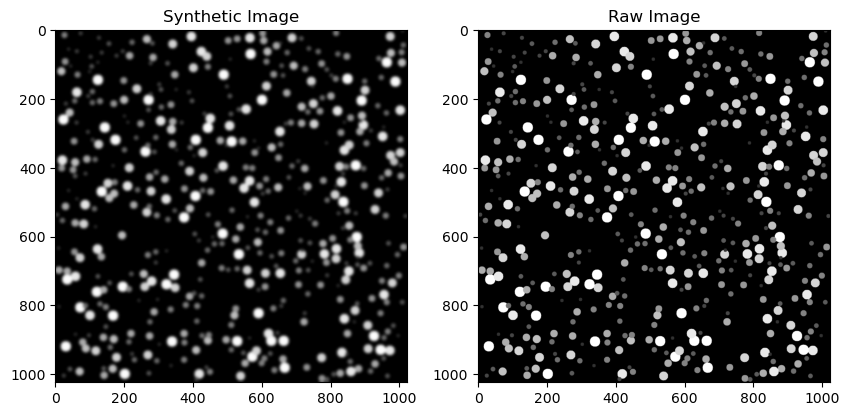

In [14]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

def create_synthetic_image(size, num_blobs, min_blob_size, max_blob_size, blur_amount, noise_level):
    image = np.zeros((size, size), dtype=np.uint8)  # Start with a dark image
    placed_centers = []
    max_attempts = 50  # Limit attempts to place a circle to avoid infinite loops

    for _ in range(num_blobs):
        for attempt in range(max_attempts):
            blob_size = np.random.randint(min_blob_size, max_blob_size + 1)
            x, y = np.random.randint(blob_size, size - blob_size, size=2)
            intensity = np.interp(blob_size, [min_blob_size, max_blob_size], [50, 255])
            
            # Check for overlap
            if all(np.linalg.norm(np.array([x, y]) - np.array(center)) >= blob_size + 5 + size // num_blobs for center in placed_centers):
                placed_centers.append((x, y))
                cv2.circle(image, (x, y), blob_size, int(intensity), -1)
                break

    # Apply Gaussian blur
    blurred_image = gaussian_filter(image, sigma=blur_amount)
    
    # Add noise
    noise = np.random.normal(0, noise_level, (size, size))
    noisy_blurred_image = np.clip(blurred_image + noise, 0, 255).astype(np.uint8)
    
    return noisy_blurred_image, image

# Parameters
image_size = 1024
num_blobs = 500
min_blob_size = 5
max_blob_size = 15
blur_amount = 4
noise_level = 1

# Generate images
image1, raw_image1 = create_synthetic_image(image_size, num_blobs, min_blob_size, max_blob_size, blur_amount, noise_level)

# Visualize the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Synthetic Image')
plt.imshow(image1, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Raw Image')
plt.imshow(raw_image1, cmap='gray')
plt.show()


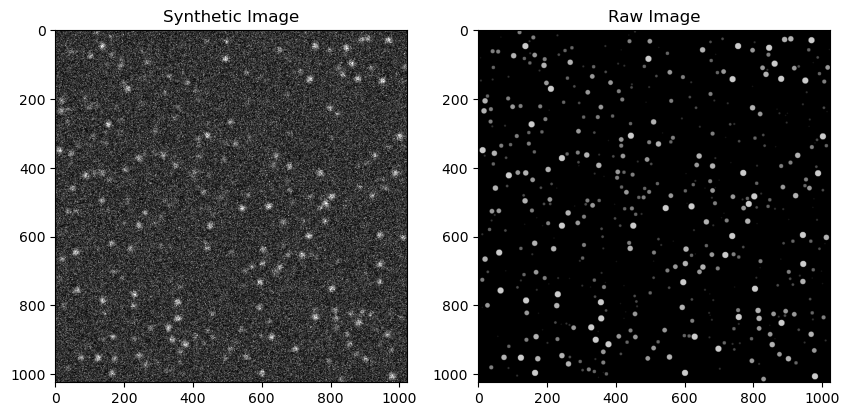

In [22]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

def create_synthetic_image(size, num_blobs, min_blob_size, max_blob_size, blur_amount, noise_level):
    image = np.zeros((size, size), dtype=np.uint16)  # Use a 16-bit dark image
    placed_centers = []
    max_attempts = 50  # Limit attempts to place a circle

    for _ in range(num_blobs):
        placed = False
        for attempt in range(max_attempts):
            blob_size = np.random.randint(min_blob_size, max_blob_size + 1)
            x, y = np.random.randint(blob_size, size - blob_size, size=2)
            intensity = np.interp(blob_size, [min_blob_size, max_blob_size], [50, 400])

            # Check for non-overlapping with a 2-pixel gap
            if all(np.linalg.norm(np.array([x, y]) - np.array(center[:2])) >= blob_size + center[2] + 2 for center in placed_centers):
                placed_centers.append((x, y, blob_size))
                # Create a grid of distances from the center of the blob
                xx, yy = np.ogrid[-x:size-x, -y:size-y]
                mask = xx**2 + yy**2 <= blob_size**2
                image[mask] = intensity
                placed = True
                break
        if not placed:
            print(f"Could not place blob after {max_attempts} attempts.")

    # Apply Gaussian blur
    blurred_image = gaussian_filter(image, sigma=blur_amount)
    
    # Add noise (scaled for 16-bit)
    noise = np.random.normal(0, noise_level * 256, (size, size))
    noisy_blurred_image = np.clip(blurred_image + noise, 0, 65535).astype(np.uint16)
    
    return noisy_blurred_image, image

# Parameters
image_size = 1024
num_blobs = 500
min_blob_size = 2
max_blob_size = 9
blur_amount = 4
noise_level = 1

# Generate images
image1, raw_image1 = create_synthetic_image(image_size, num_blobs, min_blob_size, max_blob_size, blur_amount, noise_level)

# Visualize the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Synthetic Image')
plt.imshow(image1, cmap='gray', vmin=0, vmax=500)
plt.subplot(1, 2, 2)
plt.title('Raw Image')
plt.imshow(raw_image1, cmap='gray', vmin=0, vmax=500)
plt.show()
